# Generation and evaluation

## Load libraries and datasets

In [ ]:
# @title Install and load libraries { display-mode: "form" }
# @markdown The following libraries and programs will be installed:
# @markdown - MIDItok (tokeniser)
# @markdown - Fluidsynth (MIDI to wav)
# @markdown - Muspy (Symbolic music libraries handle)
# @markdown ---
# @markdown All necessary libraries are included in this cell

%%capture
# Install MIDItok for tokenising MIDI files
!pip install miditok
# Library used to handle symbolic music datasets. Used in this case for
# Emopia and Maestro datasets
!pip install muspy
# Fluidsynth for producing wav files from midi (using a soundfont)
!pip install midi2audio
!pip install fluidsynth
# Install fluidsynth
!apt install fluidsynth
# Copy default sample of musical instruments to current directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

# Using REMI scheme tokenisation
from miditok import REMI, TokenizerConfig
# Manage paths
from pathlib import Path
import os
# Ipython.display to show audio files
import IPython.display as ipd
# Librosa for music and audio analysis
import librosa
# Symbolic music datasets library
import muspy
# To calculate information from the midi file
import music21
# To copy objects
import copy
# Pytorch
import torch

# Set datasets path
datasets_folder = 'data'
vgmidi_path  = datasets_folder + '/vgmidi'
emopia_path  = datasets_folder + '/emopia'
maestro_path = datasets_folder + '/maestro'

# Create folder for datasets
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)

In [ ]:
# @title Get datasets { display-mode: "form" }
# @markdown Datasets to download:
# @markdown - VGMIDI (from github)
# @markdown - EMOPIA (muspy)
# @markdown - MAESTRO (muspy)
%%capture
!git clone https://github.com/lucasnfe/vgmidi.git {vgmidi_path}
# Extract unlabelled midi from VGMIDI dataset
!unzip "{vgmidi_path}/unlabelled/midi.zip" -d "{vgmidi_path}/"

# Use muspy library for emopia and maestro datasets
emopia = muspy.EMOPIADataset(emopia_path, download_and_extract=True)
maestro = muspy.datasets.MAESTRODatasetV3(maestro_path, download_and_extract=True)

# Get paths of unlabelled data in VGMIDI dataset
vgmidi_unlabelled_midi_paths = list(Path("/content/data/vgmidi/midi").glob("*.mid"))
print("VGMIDI unlabelled paths", len(vgmidi_unlabelled_midi_paths))

# Get paths of labelled data in VGMIDI dataset
vgmidi_labelled_midi_paths = list(Path("/content/data/vgmidi/labelled/midi").glob("*.mid"))
print("VGMIDI labelled paths", len(vgmidi_labelled_midi_paths))

# Get paths of labelled data in EMOPIA dataset
emopia_labelled_midi_paths = list(Path("/content/data/emopia/EMOPIA_2.2/midis").glob("*.mid"))
print("EMOPIA labelled paths", len(emopia_labelled_midi_paths))

# Create list to store MAESTRO dataset paths
maestro_unlabelled_midi_paths = list()
# Get paths of unlabelled data in MAESTRO dataset
for folder in os.listdir("/content/data/maestro/maestro-v3.0.0/"):
  maestro_unlabelled_midi_paths +=  list(Path("/content/data/maestro/maestro-v3.0.0/" + folder).glob("*.mid*"))
print("MAESTRO labelled paths", len(maestro_unlabelled_midi_paths))

# Create list of combined laballed paths
combined_labelled_dataset_paths = vgmidi_labelled_midi_paths + emopia_labelled_midi_paths
print("Combined labelled paths", len(combined_labelled_dataset_paths))

# Create list of combined unlabelled paths
combined_unlabelled_dataset_paths = vgmidi_unlabelled_midi_paths + maestro_unlabelled_midi_paths
print("Combined unlabelled paths", len(combined_unlabelled_dataset_paths))

# Create list of combined labelled and unlabelled paths
combined_dataset_paths = combined_unlabelled_dataset_paths + combined_labelled_dataset_paths
print("Combined paths", len(combined_dataset_paths))

In [ ]:
# @title Clone Emotion Wave github repository { display-mode: "form" }
%%capture
!git clone https://github.com/JorgePdlR/EmotionWave.git

# Set datasets path
datasets_folder = 'data'
output_folder = 'FolderData'

truncated_folder = 'EmotionWave/vgmidi_unlabelled_truncated.zip'

!unzip "{truncated_folder}" -d "{output_folder}/"
dataset_path = output_folder + "Vgmidi_unlabelled"

In [ ]:
# @title Run to update the content from the github repository { display-mode: "form" }
# @markdown This is a no-operation if no changes has been done
%%capture
%cd EmotionWave
!git pull
%cd ..

In [ ]:
# @title Create tokeniser { display-mode: "form" }
# @markdown Create the tokeniser and load any relevant files from the projects
# @markdown github
from miditok import TokSequence
import miditok
import importlib
import EmotionWave.MIDIoperations
from EmotionWave.MIDIoperations import REMItokenizer, MidiWav
import pretty_midi
from midi2audio import FluidSynth

# Reload the module
importlib.reload(EmotionWave.MIDIoperations)

# REMI tokeniser configuration
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)

}

# Remi tokeniser
remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)

/content/EmotionWave/MIDIoperations.py:293: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.configuration = TokenizerConfig(**parameters)


In [ ]:
# @title Load dataset of fragments of 8-bar songs { display-mode: "form" }
# @markdown Load dataset and filter songs with more than 128 tokens, with not
# @markdown exactly 8-bars and with no valence associated
import re
import pickle

# Load dataset
#with open('data_8bar_ids_dict.pkl', 'rb') as pickle_file:
with open('data_8bar_ids_dict_clean.pkl', 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

# Remove all midi fragments that have sequences of tokens of more than 128
# values
val = 0
to_remove_list = []
# Go through all the 8-bar pieces of music
for bar8_path, bar8_dict in data_dict.items():
    for bar_path, bar_dict in bar8_dict.items():
        if len(bar_dict['ids']) >= 128:
            to_remove_list.append(bar8_path)
            val += 1
            # Break to avoid adding the same bar8_path multiple times
            break

print("8-bar sequences to remove with more than 128 tokens", val)

# Remove the collected keys from the outer dictionary
for path_to_remove in to_remove_list:
    data_dict.pop(path_to_remove)

print("Size of 8-bar sequences", len(data_dict))

# Remove all midi fragments that are not exactly 8 bars
val = 0
to_remove_list = []
for bar8_path, bar8_dict in data_dict.items():
    for bar_path, bar_dict in bar8_dict.items():
        if len(bar8_dict) != 8:
            to_remove_list.append(bar8_path)
            val += 1
            break

print("not 8-bar sequences to remove", val)

# Remove the collected keys from the outer dictionary
for path_to_remove in to_remove_list:
    data_dict.pop(path_to_remove)

print("Size of 8-bar sequences", len(data_dict))

# Remove midi fragments without valence
val = 0
to_remove_list = []
# Todo reduce dataset pieces smaller than 810 ? maybe 128
for bar8_path, bar8_dict in data_dict.items():
    for bar_path, bar_dict in bar8_dict.items():
        if 'valence' not in bar_dict:
            to_remove_list.append(bar8_path)
            val += 1
            break

print("no valence sequences to remove", val)

# Remove the collected keys from the outer dictionary
for path_to_remove in to_remove_list:
    data_dict.pop(path_to_remove)

print("Size of 8-bar sequences with valence", len(data_dict))

8-bar sequences to remove with more than 128 tokens 13595
Size of 8-bar sequences 55468
not 8-bar sequences to remove 4488
Size of 8-bar sequences 50980
no valence sequences to remove 0
Size of 8-bar sequences with valence 50980


In [ ]:
# @title Format dataset { display-mode: "form" }
# @markdown Format dataset as the encoder, decoder, decoder bar position,
# @markdown padding mask, and valence cls lists.

import torch

# Convert the valence to either 2 (positive) or 1 (negative) based on the
# treshold
def map_valence_to_int(valence_val, max_val):
    # 0 Value is used as padding
    if valence_val > .5:
        return int(2)
    return int(1)

vocab_dict = remi.get_vocab_dict()

pad_ids = vocab_dict['PAD_None']
bars_per_sample = 8
sequence_per_bar_length = 128
sequence_length = 1024
valence_range = 8

encoder_input_list = []
decoder_input_list = []
decoder_bar_position_list = []
padding_mask_list = []
valence_cls_list = []
valence_val_list = []

for bar8_path, bar8_dict in data_dict.items():
    # Initialise the tensor with the padding ids
    # Max size of elements in bar, number of bars
    encoder_input = torch.full((sequence_per_bar_length, bars_per_sample), pad_ids)
    # Max size of elements in a sequence
    decoder_input = torch.full((sequence_length,), pad_ids)
    # Max size of number of bars, fixed to 8 + 1 including start-end position
    decoder_bar_position = torch.zeros((bars_per_sample + 1,))
    # Number of bars, max size of elements per bar sequence
    padding_mask = torch.ones((bars_per_sample, sequence_per_bar_length), dtype=torch.bool)
    # Shape of Max size of elements in a sequence.
    valence_cls = torch.full((sequence_length,), pad_ids)
    # For statistics of the valence
    valence_val = torch.full((bars_per_sample,), pad_ids)

    offset_decoder_input = 0
    bar_seq_size = 0

    # Go through all the individual bars
    for z, (bar_path, bar_dict) in enumerate(bar8_dict.items()):
        ids_t = torch.tensor(bar_dict['ids'])
        ids_len = len(ids_t)
        encoder_input[0:ids_len, z] = ids_t

        padding_mask[z, 0:ids_len] = False

        decoder_input[offset_decoder_input: offset_decoder_input + ids_len] = ids_t
        valence_cls[offset_decoder_input: offset_decoder_input + ids_len] = map_valence_to_int(bar_dict['valence'], valence_range)
        valence_val[z] = map_valence_to_int(bar_dict['valence'], valence_range)
        offset_decoder_input += ids_len
        # Adding one because first starting position is 0, we have 8 ranges
        # that correspond to 9 positions
        decoder_bar_position[z + 1] = offset_decoder_input

        bar_seq_size += ids_len


    # Store in a list the encoder input tensor
    encoder_input_list.append(encoder_input)

    # Store in a list the decoder input tensor
    decoder_input_list.append(decoder_input)

    # Store in a list the decoder bar start end position
    decoder_bar_position_list.append(decoder_bar_position)

    # Store in a list the padding values per bar
    padding_mask_list.append(padding_mask)

    # Store in a list the valence values per sequence
    valence_cls_list.append(valence_cls)

    # Store in a list the valence values with out expansions for statistics
    valence_val_list.append(valence_val)

# Stack the tensors along a new dimension
encoder_input_tensor = torch.stack(encoder_input_list)
decoder_input_tensor = torch.stack(decoder_input_list)
decoder_target_tensor = torch.stack(decoder_input_list)
decoder_bar_position_tensor = torch.stack(decoder_bar_position_list)
padding_mask_tensor = torch.stack(padding_mask_list)
valence_cls_tensor = torch.stack(valence_cls_list)
valence_val_tensor = torch.stack(valence_val_list)

print("Encoder input", encoder_input_tensor.shape)
print("Decoder input", decoder_input_tensor.shape)
print("Decoder target", decoder_target_tensor.shape)
print("Decoder bar position", decoder_bar_position_tensor.shape)
print("Padding mask", padding_mask_tensor.shape)
# In valence per sequence the same valence value is replicated over the complete
# bar. Each bar might have a different valence. Valence is mapped to integers
# in the provided range
print("Valence per sequence", valence_cls_tensor.shape)
print("Valence statistics", valence_val_tensor.shape)

Encoder input torch.Size([50980, 128, 8])
Decoder input torch.Size([50980, 1024])
Decoder target torch.Size([50980, 1024])
Decoder bar position torch.Size([50980, 9])
Padding mask torch.Size([50980, 8, 128])
Valence per sequence torch.Size([50980, 1024])
Valence statistics torch.Size([50980, 8])


In [ ]:
# @title Auxiliar functions for generation { display-mode: "form" }
import re

# To remove unwanted charecters from the token name, useful to filter tokens
# like 'Position'
def remove_unwanted_characters(input_string):
    return re.sub(r'[\d._]+', '', input_string)

# Get latent embedding from input song. Needs encoder_input and padding mask
def get_latent_embedding(model, encoder_input, padding_mask, use_sampling=False,
                         sampling_var=0.):
    # Prepare the input tensor for the model
    encoder_input = encoder_input.long().to(device)

    # Prepare the padding mask for the model
    padding_mask = padding_mask.bool().to(device)

    # Generate latent embeddings without computing gradients
    with torch.no_grad():
        piece_latents = model.get_sampled_latent(encoder_input, padding_mask=padding_mask,
                                                 use_sampling=use_sampling, sampling_var=sampling_var)

    # Return the generated latent embeddings
    return piece_latents

# Helper function to convert numpy to tensor
def numpy_to_tensor(x, device=torch.device('cpu')):
    return torch.tensor(x, device=device).float()

# Provided the logits, calculate the softmax temperature and return the
# new probabilities
def temperatured_softmax(logits, temperature):
    try:
        # Add a small constant to prevent zero values in the exponent
        logits = logits + 1e-10
        # Calculate the probabilities
        probs = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature))
        assert torch.count_nonzero(torch.isnan(probs)) == 0
        # Trying again with more bits...
    except:
        print ('overflow detected, use 128-bit')
        logits = logits.type(torch.float128)
        # Calculate the probabilities
        probs = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature))
        # Lets save some memory and avoid funny issues with different types of
        # data
        probs = probs.type(torch.float32)
    return probs

# Provided the probabilities, compute the nuclues sampling that consists on
# removing the tails from the distribution and sampling from the new possible
# values of the distribution.
def nucleus(probs, p):
    # Normalise the input probabilities to ensure they sum to 1
    probs = probs / torch.sum(probs)
    # Sort the probabilities in descending order and get the corresponding
    # indices
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    # Compute the cumulative sum of the sorted probabilities
    cumsum_sorted_probs = torch.cumsum(sorted_probs, dim=0)
    # Filter the sorted probabilities based on the threshold p
    after_threshold = cumsum_sorted_probs > p
    # If there are any probabilities above the threshold, select the tokens
    # up to the last index before the threshold is exceeded
    if torch.sum(after_threshold) > 0:
        last_index = torch.where(after_threshold)[0][1]
        candidate_index = sorted_indices[:last_index]
    # If all probabilities are below the threshold, select the top 3 tokens
    else:
        # just assign a value
        candidate_index = sorted_indices[:3]
    # Normalise the probabilities of the selected tokens
    candidate_probs = probs[candidate_index]
    candidate_probs = candidate_probs / torch.sum(candidate_probs)
    # Randomly select a token from the candidates using multinomial sampling
    word = torch.multinomial(candidate_probs, num_samples=1).item()
    # Return the index of the selected token
    return candidate_index[word].item()


In [ ]:
# @title Generation function { display-mode: "form" }

# Provided the model, latent vector, tokeniser generate a song based on the
# provided valence. Nucleus and temperature can be provided too.
def generate_on_latent(model, latents, remi_t, valence_cls=None,
                       max_events=10240, primer=None,
                       max_input_len=1024, truncate_len=512,
                       nucleus_p=0.9, temperature=1.1, verbose=False):

    # Initialise placeholders for latent vectors and class labels
    latent_placeholder = torch.zeros(max_events, 1, latents.size(-1)).to(device)
    valence_placeholder = torch.zeros(max_events, 1, dtype=int).to(device)
    if verbose:
        print('Valence cls: {}'.format(valence_cls))

    # Initialise the generated sequence with a primer or a default start event
    if primer is None:
        # Correspnds to bar token
        generated = [4]
    else:
        # Convert each token to the corresponding id
        generated = [remi_t.token_to_id(e) for e in primer]

        # Get the portion of the latent vector that corresponds to the first bar
        latent_placeholder[:len(generated), 0, :] = latents[0].squeeze(0)

        # If valence provided store the proportional part for the first bar. Not
        # really necessary due to the approach used to have the same valence for
        # all the 8-bars. But it can be used to have different valence values in
        # the bars.
        if valence_cls is not None:
            valence_placeholder[:len(generated), 0] = valence_cls[0]

    # Get the number of bars based on the latent space. We start with 0 bars
    target_bars, generated_bars = latents.size(0), 0
    # Time for metrics
    time_st = time.time()
    # Keep track of the current token
    cur_pos = 0
    # keep track of the model fails to create different tokens
    failed_cnt = 0
    # Size of the input (primer)
    cur_input_len = len(generated)
    # Generated tokens
    generated_final = deepcopy(generated)
    # Calculate the entropies
    entropies = []
    # Generated word event
    word_event = ""

    # Keep going until all bars are generated
    while generated_bars < target_bars:
        # Prepare the input for the model
        if len(generated) == 1:
            decoder_input = numpy_to_tensor([generated], device=device).long()
        else:
            decoder_input = numpy_to_tensor([generated], device=device).permute(1, 0).long()

        # Prepare the latent vector
        latent_placeholder[len(generated) - 1, 0, :] = latents[generated_bars]
        # Prepare the valence vector
        if valence_cls is not None:
            valence_placeholder[len(generated)-1, 0] = valence_cls[generated_bars]

        # Set condition vector
        condition_embedding = latent_placeholder[:len(generated), :]

        # Set valence placeholder information to the decoder valence
        if valence_cls is not None:
            decoder_valence_cls = valence_placeholder[:len(generated), :]
        else:
            decoder_valence_cls = None

        # Stop if we reach the limit
        if len(generated) > truncate_len:
            break

        # Generate the next token
        with torch.no_grad():
            # Get the logits from the model
            logits = model.generate(decoder_input, condition_embedding, decoder_valence_cls, verbose=False)

        # Convert the logits to a tensor
        logits = numpy_to_tensor(logits[0])

        # Temperatured softmax
        probs = temperatured_softmax(logits, temperature)

        # Nucleus sampling
        word = nucleus(probs, nucleus_p)

        # Remove unwanted characters from the token
        prev_word_event = remove_unwanted_characters(word_event)
        # Convert the token to the corresponding id
        word_event = remi_t.id_to_token(word)

        # If token is position make sure that we are making progress
        if 'Position' in word_event:
            event_pos = word
            # If we are not increasing the positoin add one to the fail count
            if not event_pos > cur_pos:
                failed_cnt += 1
                if verbose:
                    print ('Position not increasing, failed cnt:', failed_cnt)
                # More than 128 failed token, return the generated values so far
                if failed_cnt >= 128:
                    if verbose:
                        print ('Model stuck, exiting ...')
                    return generated
                continue
            # All good we are making progress, store the new position
            else:
                cur_pos = event_pos
                failed_cnt = 0

        # A bar was generated, add one to the number of generated bars. Retart
        # the position counter since it starts counting per bar
        if 'Bar' in word_event:
            generated_bars += 1
            cur_pos = 0
        if verbose:
            print('Generated {} bars, #events = {}'.format(generated_bars, len(generated_final)))

        # Store the generated tokens and entropies
        generated.append(word)
        generated_final.append(word)
        entropies.append(entropy(probs))

        # Increase the current input length
        cur_input_len += 1

        # This two should match
        assert cur_input_len == len(generated)

        # Stop if we reach the total limit of max input length
        if cur_input_len == max_input_len:
            generated = generated[-truncate_len:]
            latent_placeholder[:len(generated)-1, 0, :] = latent_placeholder[cur_input_len-truncate_len:cur_input_len-1, 0, :]
            valence_placeholder[:len(generated)-1, 0] = valence_placeholder[cur_input_len-truncate_len:cur_input_len-1, 0]

            if verbose:
                print('Reset context length: cur_len: {}, accumulated_len: {}, truncate_range: {} ~ {}'.format(
                      cur_input_len, len(generated_final), cur_input_len-truncate_len, cur_input_len-1))

            cur_input_len = len(generated)

            break

    if verbose:
        print('Generated events:', len(generated_final))
        print('Time elapsed: {:.2f} secs'.format(time.time() - time_st))

    # Return the generated tokens, spent time and the entropies
    return generated_final[:-1], time.time() - time_st, np.array(entropies)


## Generation time! you can either load a song or use any song from the dataset

Model needs to be uploaded and loaded, check train ipynb file to create a trained version of EmotionWave

In [ ]:
# @title Format input

path_midi = "/content/Mario Bros. - Super Mario Bros. Theme.mid" # @param {type:"string"}
track_num = 0 # @param Defalut is 0, change just for songs with more than one track

TOKENIZER_PARAMS ={
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}

remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)
current = MidiWav(path_midi)
tokenized_song = remi.tokenize_midi_file(current.midi_path)

vocab_dict = remi.get_vocab_dict()
pad_ids = vocab_dict['PAD_None']
bars_per_sample = 8
sequence_per_bar_length = 128
sequence_length = 1024
valence_range = 8

_, divided_song = remi.split_in_groups_of_bars(tokenized_song, num_of_bars=1, any_num_of_tracks=True)

encoder_input = torch.full((sequence_per_bar_length, bars_per_sample), pad_ids)
# Max size of elements in a sequence
decoder_input = torch.full((sequence_length,), pad_ids)
# Max size of number of bars, fixed to 8 + 1 including start-end position
decoder_bar_position = torch.zeros((bars_per_sample + 1,)).int()
# Number of bars, max size of elements per bar sequence
padding_mask = torch.ones((bars_per_sample, sequence_per_bar_length), dtype=torch.bool)
# Shape of Max size of elements in a sequence.
valence_cls = torch.full((sequence_length,), pad_ids)
# For statistics of the valence
valence_val = torch.full((bars_per_sample,), pad_ids)


offset_decoder_input = 0
bar_seq_size = 0

for j, fragment_song in enumerate(divided_song):
    # Exit after we have all the bars per sample
    if j >= bars_per_sample:
        break

    # Get bar
    ids_t = torch.tensor(fragment_song[track_num].ids)
    ids_len = len(ids_t)
    encoder_input[0:ids_len, j] = ids_t

    padding_mask[j, 0:ids_len] = False
    decoder_input[offset_decoder_input: offset_decoder_input + ids_len] = ids_t

    decoder_input[offset_decoder_input: offset_decoder_input + ids_len] = ids_t
    valence_cls[offset_decoder_input: offset_decoder_input + ids_len] = map_valence_to_int(bar_dict['valence'], valence_range)
    valence_val[j] = map_valence_to_int(bar_dict['valence'], valence_range)
    offset_decoder_input += ids_len
    # Adding one because first starting position is 0, we have 8 ranges
    # that correspond to 9 positions
    decoder_bar_position[j + 1] = offset_decoder_input


# Get original song
original_song = encoder_input.permute(1,0).reshape(-1).tolist()
remi.ids_to_midi("original.mid", [original_song])
current = MidiWav("original.mid")
current.convert_to_wav("original.wav", sound_font='font.sf2')
print(current.wav_path)
current.reproduce_audio()


original.wav


In [ ]:
# @title Process midi helper function { display-mode: "form" }
# @markdown If .mid provided, generate the input data from the file with the
# @markdown process_midi function

from EmotionWave.MIDIoperations import REMItokenizer, MidiWav

def process_midi(path_midi, track_num, TOKENIZER_PARAMS, reproduce_song=False):
    # Initialize the REMI tokeniser
    remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)
    current = MidiWav(path_midi)
    tokenized_song = remi.tokenize_midi_file(current.midi_path)

    vocab_dict = remi.get_vocab_dict()
    pad_ids = vocab_dict['PAD_None']
    bars_per_sample = 8
    sequence_per_bar_length = 128
    sequence_length = 1024
    valence_range = 8

    # Split the tokenised song into groups of bars
    _, divided_song = remi.split_in_groups_of_bars(tokenized_song, num_of_bars=1, any_num_of_tracks=True)

    # Initialise the input tensors
    encoder_input = torch.full((sequence_per_bar_length, bars_per_sample), pad_ids)
    decoder_input = torch.full((sequence_length,), pad_ids)
    decoder_bar_position = torch.zeros((bars_per_sample + 1,)).int()
    padding_mask = torch.ones((bars_per_sample, sequence_per_bar_length), dtype=torch.bool)
    valence_cls = torch.full((sequence_length,), pad_ids)
    valence_val = torch.full((bars_per_sample,), pad_ids)

    offset_decoder_input = 0
    bar_seq_size = 0

    # Fill the input tensors with the tokenised MIDI data
    for j, fragment_song in enumerate(divided_song):
        if j >= bars_per_sample:
            break

        # Get the tokenised data for the current track
        ids_t = torch.tensor(fragment_song[track_num].ids)
        ids_len = len(ids_t)
        # Fill the encoder input tensor
        encoder_input[0:ids_len, j] = ids_t

        # Update the padding mask
        padding_mask[j, 0:ids_len] = False
        # Fill the decoder input tensor
        decoder_input[offset_decoder_input: offset_decoder_input + ids_len] = ids_t


        # Fill the valence class and value tensors
        valence_cls[offset_decoder_input: offset_decoder_input + ids_len] = map_valence_to_int(bar_dict['valence'], valence_range)
        valence_val[j] = map_valence_to_int(bar_dict['valence'], valence_range)
        # Update the offset for the decoder input
        offset_decoder_input += ids_len
        # Update the decoder bar position tensor
        decoder_bar_position[j + 1] = offset_decoder_input

    # Optionally, reproduce the original song
    if reproduce_song:
        # Reshape the encoder input to a 1D tensor
        original_song = encoder_input.permute(1,0).reshape(-1).tolist()
        # Convert the tokenised data back to a MIDI file
        remi.ids_to_midi("original.mid", [original_song])
        current = MidiWav("original.mid")
        current.convert_to_wav("original.wav", sound_font='font.sf2')
        print(current.wav_path)
        current.reproduce_audio()

    return encoder_input, decoder_input, decoder_bar_position, padding_mask, valence_cls, valence_val, remi

encoder_input, decoder_input, decoder_bar_position, padding_mask, valence_cls, valence_val, remi = process_midi(path_midi, track_num, TOKENIZER_PARAMS)

/content/EmotionWave/MIDIoperations.py:293: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.configuration = TokenizerConfig(**parameters)


In [ ]:
# @title Load model
from EmotionWave.MIDIoperations import REMItokenizer, MidiWav
import torch.optim.lr_scheduler as lr_scheduler
import EmotionWave.Model.EmotionWave as emw
import EmotionWave.MIDIoperations
from scipy.stats import entropy
from copy import deepcopy
import numpy as np
import importlib
import time
import gc

sequence_per_bar_length = 128
sequence_length = 1024

# Reload the module
importlib.reload(EmotionWave.Model.EmotionWave)

gc.collect()

# Empty the CUDA cache to free up GPU memory
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model_dir = 'Models'
log_dir = 'Logs'
log_file = 'log'

vocab_dict_size = len(remi.get_vocab_dict())
valence_dim_embeddings=128



# Model
emw_model = emw.EmotionWave(10,              # Encoder number of layers
                            512,             # Encoder dimensions
                            8,               # Encoder number of heads
                            2048,            # Encoder dimensions feedforward
                            128,             # Dimensions latent VAE
                            512,             # Dimensions embedding
                            vocab_dict_size, # Number of embeddings
                            10,              # Decoder number of layers
                            512,             # Decoder dimensions
                            8,               # Decoder number of heads
                            2048,            # Valence number CLS
                            valence_dim_embeddings=valence_dim_embeddings,
                            valence_num_cls=3, # Valence vocabulary
                            valence_cls=True
                            )



#pretrained_params_path = '/content/Models_17_0.74600126709495460.1964891192268273.pt'
pretrained_params_path = '/content/Models_20_0.73625825994310780.29909917901890815.pt'
#emw_model.load_state_dict(torch.load(pretrained_params_path, map_location=torch.device('cpu')))
emw_model.load_state_dict(torch.load(pretrained_params_path))

print(emw_model)

cuda:0
EmotionWave(
  (input_embedding): EmbeddingWithProjection(
    (embedding_lookup): Embedding(267, 512)
  )
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): VAETransformerEncoder(
    (transformer_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
     

In [ ]:
# @title Autoregresive generation (token by token generation)

# Comment if user input song is going to be used
# song_idx = 5216
#encoder_input = encoder_input_tensor[song_idx].to(device)
#padding_mask = padding_mask_tensor[song_idx].to(device)

# Comment if song from data set is going to be used
encoder_input, decoder_input, decoder_bar_position, padding_mask, valence_cls, valence_val, remi = process_midi(path_midi, track_num, TOKENIZER_PARAMS)

# Get original song
original_song = encoder_input.permute(1,0).reshape(-1).tolist()
remi.ids_to_midi("original.mid", [original_song])
current = MidiWav("original.mid")
current.convert_to_wav("original.wav", sound_font='font.sf2')
print(current.wav_path)
current.reproduce_audio()

emw_model.eval()
emw_model.to(device)

new_tokens = [remi.id_to_token(new_token) for new_token in original_song[0:-1]]

# Condition the generation with the first N tokens
primer = new_tokens[0:15]
#primer = None

for i in range(2):
    # Use valence with same value for all the vector
    #valence_cls = torch.full((sequence_length,), i + 1).to(device)
    #valence_cls = None

    # Set valence in the exact positions
    converted_tensor = padding_mask.permute(1,0).reshape(-1)
    valence_cls = (~converted_tensor).int() * (i + 1)

    # Generate latent space from the song
    g_latent = get_latent_embedding(emw_model, encoder_input, padding_mask)
    # Use for testing
    fake_latent = torch.full((g_latent.size(0), g_latent.size(1)), 0).to(device)

    # Generate the song!
    song, t_sec, entropies = generate_on_latent(emw_model, g_latent, remi, valence_cls, primer=primer, nucleus_p=0.70, temperature=1.2, verbose=False)

    # Convert the generated ids to a .mid file
    remi.ids_to_midi("new_file.mid", [song])

    # Load .mid file
    current = MidiWav("new_file.mid")

    # Convert to wav format
    current.convert_to_wav("test.wav", sound_font='font.sf2')
    print(current.wav_path)
    current.reproduce_audio()

original.wav


<ipython-input-8-e938cbb28475>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, device=device).float()


test.wav


<ipython-input-8-e938cbb28475>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, device=device).float()


test.wav


## Objective evaluation of generated files


### Measure Valence using ValenceNet
ValenceNet needs to be loaded to measure the imbued valence on the generated pieces.

In [ ]:
# @title Generate positive and negative samples from the test set { display-mode: "form" }
# @markdown Store .mid files from the test set in a folder and generate a positive and
# @markdown negative sample from the original

sequence_per_bar_length = 128
sequence_length = 1024

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}

remi = REMItokenizer(TOKENIZER_PARAMS, max_bar_embedding=None)

print(type(test_data_t))
for key, value in test_data_t.items():
    print(f"{key}: {value.shape}")

encoder_input_test = test_data_t['encoder_input']
decoder_input_test = test_data_t['decoder_input']
decoder_target_test = test_data_t['decoder_target']
decoder_bar_position_test = test_data_t['decoder_bar_position']
padding_mask_test = test_data_t['padding_mask']
valence_cls_test = test_data_t['valence_cls']

dir_test_name = 'testMids2'

if not os.path.exists(dir_test_name):
    os.makedirs(dir_test_name)

processed_fragments = 0
# Store the test .mid files in a folder
for song_idx in range(len(encoder_input_test)):
    #####################
    ### Original song ###
    #####################
    encoder_input = encoder_input_test[song_idx]
    padding_mask = padding_mask_test[song_idx]
    converted_tensor = padding_mask.permute(1,0).reshape(-1)
    # Get original song
    original_song = encoder_input.permute(1,0).reshape(-1).tolist()

    # Create name with folder path
    midi_name_test = "test_" + str(song_idx) + ".mid"
    midi_name_path = dir_test_name + "/" + midi_name_test

    new_tokens = [remi.id_to_token(new_token) for new_token in original_song[0:15]]
    primer = new_tokens[0:15]

    #######################
    ### Generated songs ###
    #######################
    decoder_input = decoder_input_test[song_idx]
    decoder_bar_position = decoder_bar_position_test[song_idx].int()

    emw_model.eval().to(device)
    temperature_p = 1.1
    nucleus_p = 0.9

    ########################
    ### positive valence ###
    ########################
    valence_val = 2

    # Set valence in the exact positions
    converted_tensor = padding_mask.permute(1,0).reshape(-1)
    valence_cls = (~converted_tensor).int() * valence_val
    valence_cls.to(device)

    g_latent = get_latent_embedding(emw_model, encoder_input, padding_mask)

    try:
        new_ids_p, t_sec, entropies = generate_on_latent(emw_model, g_latent, remi, valence_cls,
                                                         primer=primer, nucleus_p=nucleus_p, temperature=temperature_p)
    except:
        continue

    midi_name_test_positive = "test_" + str(song_idx) + "_" + str(valence_val) + "_" + str(temperature_p) + "_" + str(nucleus_p) + ".mid"
    midi_name_path_positive = dir_test_name + "/" + midi_name_test_positive

    ########################
    ### negative valence ###
    ########################
    valence_val = 1

    # Set valence in the exact positions
    converted_tensor = padding_mask.permute(1,0).reshape(-1)
    valence_cls = (~converted_tensor).int() * valence_val
    valence_cls.to(device)

    g_latent = get_latent_embedding(emw_model, encoder_input, padding_mask)

    try:
        new_ids_n, t_sec, entropies = generate_on_latent(emw_model, g_latent, remi, valence_cls,
                                                         primer=primer, nucleus_p=nucleus_p, temperature=temperature_p)
    except:
        continue

    midi_name_test_negative = "test_" + str(song_idx) + "_" + str(valence_val) + "_" + str(temperature_p) + "_" + str(nucleus_p) + ".mid"
    midi_name_path_negative = dir_test_name + "/" + midi_name_test_negative

    ########################
    ###      Store       ###
    ########################
    # Store if original, negative and positive were generated
    # Store midi file
    remi.ids_to_midi(midi_name_path, [original_song])
    remi.ids_to_midi(midi_name_path_positive, [new_ids_p])
    remi.ids_to_midi(midi_name_path_negative, [new_ids_n])
    processed_fragments += 1

    if processed_fragments % 100 == 0:
        print("Processed songs: ", processed_fragments)

    # Current limit for speed
    if processed_fragments == 300:
        break


/content/EmotionWave/MIDIoperations.py:293: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.configuration = TokenizerConfig(**parameters)
<ipython-input-8-e938cbb28475>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, device=device).float()


<class 'dict'>
encoder_input: torch.Size([5098, 128, 8])
decoder_input: torch.Size([5098, 1024])
decoder_target: torch.Size([5098, 1024])
decoder_bar_position: torch.Size([5098, 9])
padding_mask: torch.Size([5098, 8, 128])
valence_cls: torch.Size([5098, 1024])
Processed songs:  100
Processed songs:  200
Processed songs:  300


In [ ]:
# @title Zip the generated files { display-mode: "form" }
import shutil

folder_to_zip = '/content/testMids2'
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)
print(f'Zipped {folder_to_zip} to {folder_to_zip}.zip')

Zipped /content/testMids2 to /content/testMids2.zip


In [ ]:
# Get the fragments from the test folder
import torch
from pathlib import Path
import torch.nn as nn
import torch.optim as optim

dir_test_name = 'testMids2'
test_paths = list(Path("./" + dir_test_name).glob("*.mid"))
print(len(test_paths))

900


In [ ]:
# @title Load ValenceNet { display-mode: "form" }
class ValenceNet(nn.Module):
    def __init__(self):
        super(ValenceNet, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)

        # Initialize weights
        self.apply(self._init_weights)

    # Init weights are different depending on the type of module
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Load ValenceNet
model_valence = ValenceNet().to(device)
# Provide the name of the file that contains the parameters of ValenceNet
valence_model = "best_model_valence_1.pkl"
# Load ValenceNet
model_valence.load_state_dict(torch.load(valence_model, map_location=device))
# Update if needed, this was computed when training ValenceNet
# TODO: update to obtain directly this values from either the .pkl file or
# a .yaml file
train_mean = torch.tensor([[0.5698]])
train_std = torch.tensor([[0.3679]])


In [ ]:
# @title Helper functions to compute low-level musical features { display-mode: "form" }

from music21 import converter, analysis, chord, meter, note
from mido import MidiFile
import mido
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import re
import numpy as np
from scipy.signal import find_peaks

# Get Mode by analysing the key
def get_mode(midi_file):
    try:
        # Convert midi file to a score using music21
        score = converter.parse(midi_file)
        # Get the key
        key = score.analyze('key')
        # Return the key mode
        return key.mode
    # There is no key
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Articulation (Legato vs. Staccato): The length and connection of notes.
def get_rhythmic_articulation(midi_file):
    # Parse MIDI file using Mido library
    midi = MidiFile(midi_file)
    # List to store note durations
    note_durations = []
    for track in midi.tracks:
        time = 0
        # Store note on time
        note_on_time = None
        # Go through each message in the track
        for msg in track:
            # Add time in the message
            time += msg.time
            # If this is a note on type and we have a velocity store the note on time
            if msg.type == 'note_on' and msg.velocity > 0:
                note_on_time = time
            # Compute duration when the note is of as the time versus the previous note on time
            elif note_on_time is not None and (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
                duration = time - note_on_time
                # Store duration of this note
                note_durations.append(duration)
                note_on_time = None
    # Getting the rhythmic articulation as the standard deviation
    return np.std(note_durations)

# Melodic Contour: The shape and direction of the melody.
def get_melodic_contour(midi_file):
    try:
        # Parse MIDI file using Music21
        score = converter.parse(midi_file)
        notes = score.flatten().notes
        intervals = []
        # Go through all the notes
        for i in range(1, len(notes)):
            # Check if the current and previous elements have a pitch attribute
            if hasattr(notes[i], 'pitch') and hasattr(notes[i-1], 'pitch'):
                interval = notes[i].pitch.midi - notes[i-1].pitch.midi
                intervals.append(interval)
            elif isinstance(notes[i], chord.Chord) and isinstance(notes[i-1], chord.Chord):
                # If both elements are chords, calculate the interval based on the root note
                interval = notes[i].root().midi - notes[i-1].root().midi
                intervals.append(interval)
        avg_interval = np.mean(intervals) if intervals else 0
        return avg_interval
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Compute musical attributes faster, same as previous functions but the parsing of the
# MIDI files is done just once per file, and not per attribute
def get_musical_attributes_2(midi_file):
    score = converter.parse(midi_file)
    chords = score.chordify()
    midi = MidiFile(midi_file)

    # Key mode
    a_key_mode = None
    try:
        a_key_mode = score.analyze('key')
        a_key_mode = a_key_mode.mode
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

    # Melodic contour
    avg_interval = None
    try:
        notes = score.flatten().notes  # Use flat instead of flatten() for music21
        intervals = []
        for i in range(1, len(notes)):
            # Check if the current and previous elements have a pitch attribute
            if hasattr(notes[i], 'pitch') and hasattr(notes[i-1], 'pitch'):
                interval = notes[i].pitch.midi - notes[i-1].pitch.midi
                intervals.append(interval)
            elif isinstance(notes[i], chord.Chord) and isinstance(notes[i-1], chord.Chord):
                # If both elements are chords, calculate the interval based on the root note
                interval = notes[i].root().midi - notes[i-1].root().midi
                intervals.append(interval)
        avg_interval = np.mean(intervals) if intervals else 0
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

    # Articulation
    note_durations = []
    for track in midi.tracks:
        time = 0
        note_on_time = None
        for msg in track:
            time += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                note_on_time = time
            elif note_on_time is not None and (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
                duration = time - note_on_time
                note_durations.append(duration)
                note_on_time = None

    std_note_duration = np.std(note_durations)

    return a_key_mode, avg_interval, std_note_duration

# Compute the energy of a MIDI file based on average velocity, note density,
# rythmic intensity, pitch range and tempo factor
def calculate_midi_energy(midi_file):
    mid = mido.MidiFile(midi_file)

    # Initialize variables
    note_events = []
    tempo = 500000  # Default tempo (120 BPM in microseconds per beat)

    # Process MIDI messages
    for track in mid.tracks:
        time = 0
        for msg in track:
            time += msg.time
            if msg.type == 'set_tempo':
                tempo = msg.tempo
            elif msg.type == 'note_on' and msg.velocity > 0:
                note_events.append((time, msg.note, msg.velocity))

    if not note_events:
        return 0  # No notes found, return minimum energy

    # Convert tempo to BPM
    tempo_bpm = mido.tempo2bpm(tempo)

    # Calculate duration in seconds
    duration = max(event[0] for event in note_events) / mid.ticks_per_beat * (60 / tempo_bpm)

    # Extract features
    velocities = np.array([event[2] for event in note_events])
    pitches = np.array([event[1] for event in note_events])
    note_times = np.array([event[0] for event in note_events])

    # 1. Loudness
    avg_velocity = np.mean(velocities)
    velocity_range = np.max(velocities) - np.min(velocities)

    # 2. Note density
    note_density = len(note_events) / duration

    # 3. Rhythmic intensity
    iois = np.diff(note_times)
    rhythmic_intensity = 1 / np.mean(iois) if len(iois) > 0 else 0

    # 4. Pitch range
    pitch_range = np.max(pitches) - np.min(pitches)

    # 5. Tempo factor
    tempo_factor = tempo_bpm / 120  # Normalize around 120 BPM

    # Combine factors to calculate energy
    energy = (
        0.3 * (avg_velocity / 127) +
        0.2 * (note_density / 8) +  # Assuming 10 notes/second is very high
        0.2 * (rhythmic_intensity / 8) +  # Assuming 10 notes/second is very high
        0.1 * (pitch_range / 88) +  # 88 is the range of a piano
        0.2 * tempo_factor
    )

    return min(1, max(0, energy))  # Ensure energy is between 0 and 1

# Get name from the path without the extension, E.g. file (.mid) removed
def get_name_from_path_without_extension(file_path):
    base_name = os.path.basename(file_path)
    name, _ = os.path.splitext(base_name)
    return name

# Since songs were fragmented remove the extensions and the fragment number
def get_name_from_path_without_extension_and_part_number(file_path):
    # Use regex to remove the part number (e.g., "_1", "_14")
    name = re.sub(r'_\d+$', '', get_name_from_path_without_extension(file_path))
    return name

In [ ]:
# Sort the list as original, negative, positive

# Sort the files using the custom key
def sort_key(path):
    # Extract numbers from the path using regex
    numbers = re.findall(r'\d+', str(path))
    # Convert extracted numbers to integers for comparison
    return [int(num) for num in numbers]

# Sort the files using the custom key
test_paths = sorted(test_paths, key=sort_key)

for new_path in test_paths[0:15]:
    print(str(new_path))

testMids3/test_0.mid
testMids3/test_0_1_1.1_0.9.mid
testMids3/test_0_2_1.1_0.9.mid
testMids3/test_1.mid
testMids3/test_1_1_1.1_0.9.mid
testMids3/test_1_2_1.1_0.9.mid
testMids3/test_2.mid
testMids3/test_2_1_1.1_0.9.mid
testMids3/test_2_2_1.1_0.9.mid
testMids3/test_3.mid
testMids3/test_3_1_1.1_0.9.mid
testMids3/test_3_2_1.1_0.9.mid
testMids3/test_4.mid
testMids3/test_4_1_1.1_0.9.mid
testMids3/test_4_2_1.1_0.9.mid


In [ ]:
# @title Compute low-level musical features of the generated samples { display-mode: "form" }

mode_list_t = []
rhythmic_articulation_list_t = []
contour_list_t = []
energy_list_t = []

predicted_valence_list_t = []

# Path
path_of_fragments_list_t = []
# Valence
valence_list_t = []
valence_8bar_test = []

fragment_index = 0

# Predict valence
model_valence.eval()

# Get the valence per 8bar segment
for song_idx in range(len(encoder_input_test)):
    valence_8bar_test.append(valence_cls_test[song_idx][0])

# Create dictionary for each VGMIDI labelled fragment
for index, midi_file in enumerate(test_paths):
    # 1 = original
    # 2 = negative
    # 0 = positive
    current_file = (index + 1) % 3
    # Compute musical attributes
    a_mode, a_contour, a_art = get_musical_attributes_2(midi_file)
    try:
        a_energy = calculate_midi_energy(midi_file)
    except:
        continue

    # skip this file if it cannot be determined
    if a_mode is None:
        continue

    # Append gathered information to the corresponding list
    # Music attributes
    mode_list_t.append(a_mode)
    rhythmic_articulation_list_t.append(a_art)
    contour_list_t.append(a_contour)
    energy_list_t.append(a_energy)

    # Compute predicted valence
    # Change minor and major to a numerical index
    if a_mode == 'minor':
        mode_number = int(0)
    elif a_mode == 'major':
        mode_number = int(1)

    # Use energy and mode to predict the valence
    musical_attr = torch.tensor([mode_number, float(a_energy)]).to(device)
    musical_attr = (musical_attr - train_mean.to(device)) / train_std.to(device)
    predicted_valence = model_valence(musical_attr).item()

    predicted_valence = int(predicted_valence > .5) + 1
    predicted_valence_list_t.append(predicted_valence)

    path_of_fragments_list_t.append(midi_file)

    # Original
    if current_file == 1:
        valence = valence_8bar_test[fragment_index].item()
    # Negative
    elif current_file == 2:
        valence = 1
    # Positive
    else:
        valence = 2
    valence_list_t.append(valence)

    if current_file == 0:
        fragment_index += 1

    # To not think that this function is doing nothing :)
    if index % 1000 == 0:
        print("Processed songs: ", index)

print(len(mode_list_t))
print(len(rhythmic_articulation_list_t))
print(len(contour_list_t))
print(len(energy_list_t))
print(len(path_of_fragments_list_t))
print(len(valence_list_t))
print(len(predicted_valence_list_t))

In [ ]:
# @title Order metrics from the original, and positive and negative generated samples { display-mode: "form" }
# @markdown Change the list_t to plot the statistics of the desired feature. Right now
# @markdown it will compute valence list
original_list_t = []
negative_list_t = []
positive_list_t = []

original_list_g = []
negative_list_g = []
positive_list_g = []

predicted_list_t = []
true_list_t = []

# Update here which list wants to be filtered in positive, negative and original
for index, param_val in enumerate(predicted_valence_list_t):
    current_file = (index + 1) % 3

    new_val = param_val

    if param_val == 'major':
        new_val = 1
    elif param_val == 'minor':
        new_val = 0

    # Original
    if current_file == 1:
        original_list_t.append(new_val)
        original_list_g.append(valence_list_t[index])
    # Negative
    elif current_file == 2:
        negative_list_t.append(new_val)
        negative_list_g.append(valence_list_t[index])

        true_list_t.append(valence_list_t[index])
        predicted_list_t.append(new_val)
    # Positive
    else:
        positive_list_t.append(new_val)
        positive_list_g.append(valence_list_t[index])

        true_list_t.append(valence_list_t[index])
        predicted_list_t.append(new_val)


class_names = ['Negative', 'Positive']

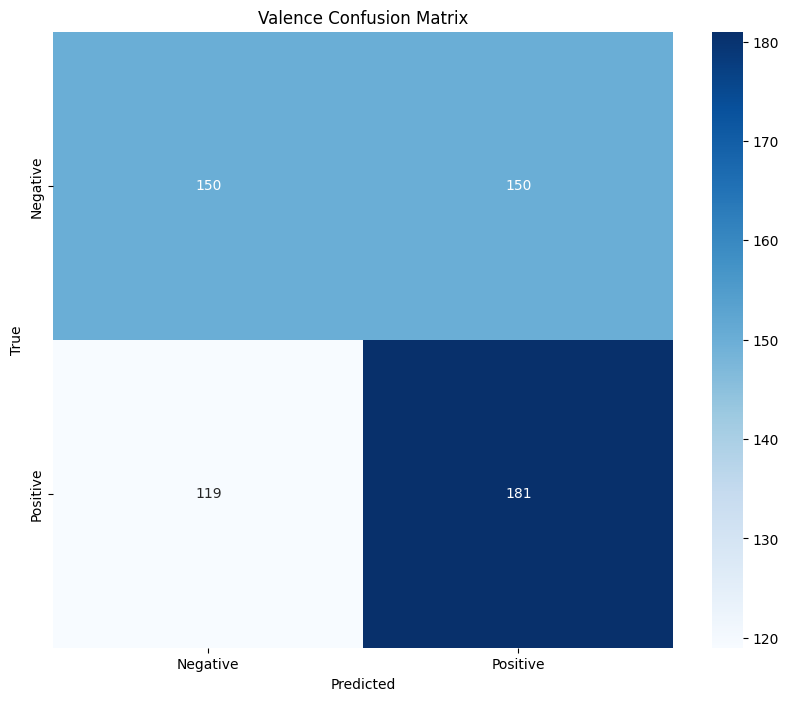

0.5516666666666666


In [ ]:
# @title Compute confusion matrix { display-mode: "form" }

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Create a figure and axis
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Set labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Valence Confusion Matrix')

    # Show the plot
    plt.show()

    return cm, accuracy

cm, accuracy = compute_confusion_matrix(true_list_t, predicted_list_t, class_names)

print(accuracy)

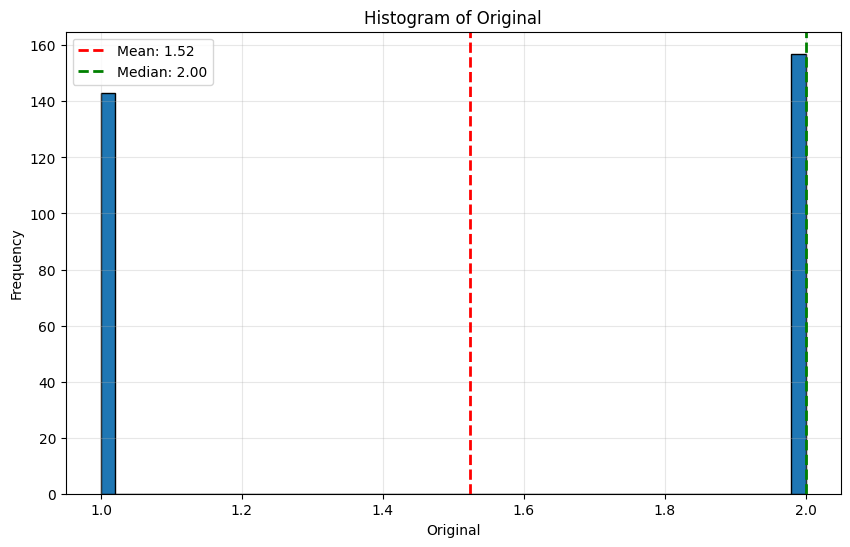

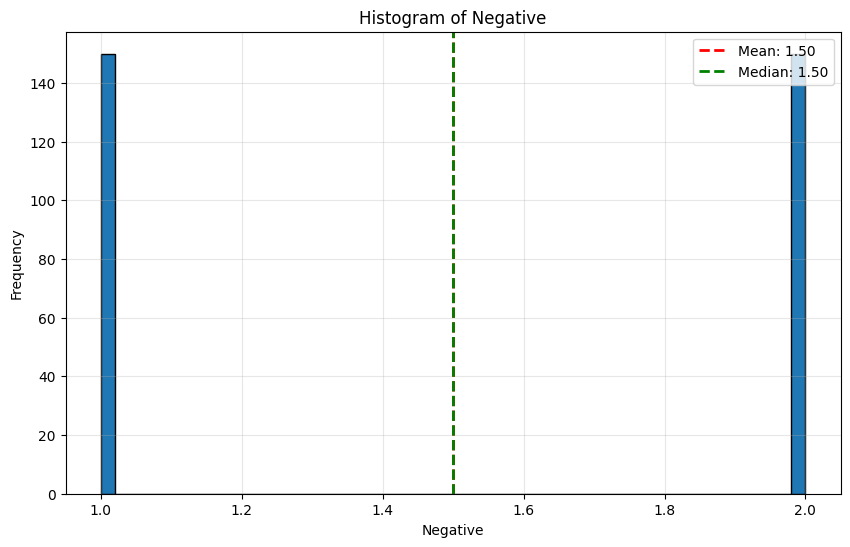

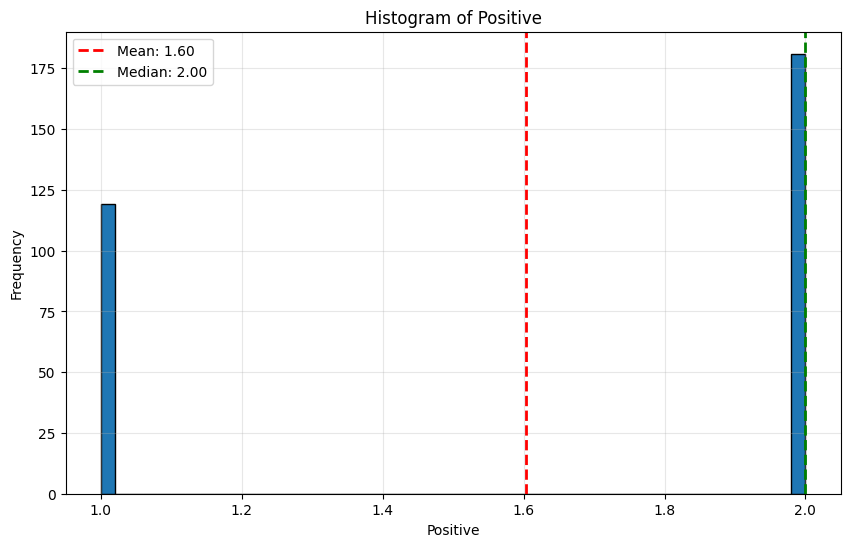

In [ ]:
# @title Plot histograms { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(data_scores, title):
    plt.figure(figsize=(10, 6))

    # Create histogram
    n, bins, patches = plt.hist(data_scores, bins=50, edgecolor='black')

    # Add labels and title
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + title)

    # Add grid
    plt.grid(alpha=0.3)

    # Add mean and median lines
    mean = np.mean(data_scores)
    median = np.median(data_scores)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

plot_histogram(original_list_t, 'Original')
plot_histogram(negative_list_t, 'Negative')
plot_histogram(positive_list_t, 'Positive')

### Style transfer, measuring similarity

In [ ]:
# @title Compute the cosine similarity { display-mode: "form" }

import numpy as np
from collections import Counter
from typing import List, Dict
from sklearn.metrics.pairwise import cosine_similarity

# Compute term frequency for a song
def compute_tf(tokenised_song):
    # Count the number of occurences of each token
    tf_dict = Counter(tokenised_song[0].tokens)

    # Normalise the ocurrences
    for token in tf_dict:
        tf_dict[token] = tf_dict[token] / len(tokenised_song[0].tokens)

    return tf_dict

# Compute the inverse document frequency
def compute_idf(tokenised_songs, vocab):
    n_songs = len(tokenised_songs)

    # Set to 0 the count of each token in the vocabulary
    idf_dict = {token: 0 for token in vocab}

    # Go through all the songs
    for midi_song in tokenised_songs:
        # Count just if the token appears in the song, not how many times
        for token in set(midi_song[0].tokens):
            idf_dict[token] += 1

    # Compute the IDF
    for token, count in idf_dict.items():
        idf_dict[token] = np.log(n_songs / (count + 1)) + 1

    return idf_dict

# Compute the TF-IDF vector for a song
def compute_tfidf_vector(tokenised_song, vocab, idf_dict):
    # Compute the term frequency for a song
    tf_dict = compute_tf(tokenised_song)
    # Fill in with zeros the tfidf vector
    tfidf_vector = np.zeros(len(vocab))

    # Go through all the tokens in the vocabulary
    for token, idx in vocab.items():
        # Get the frequency of the current token
        tf = tf_dict.get(token, 0)
        # Get the idf for the current token
        idf = idf_dict[token]
        # Compute the TF-IDF value for this token and add it to the vector
        tfidf_vector[idx] = tf * idf
    return tfidf_vector

# Compute the cosine similarity between two midi songs
def compute_similarity(tokenised_song1, tokenised_song2, vocab, idf_dict):
    vec1 = compute_tfidf_vector(tokenised_song1, vocab, idf_dict)
    vec2 = compute_tfidf_vector(tokenised_song2, vocab, idf_dict)
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]


TOKENIZER_PARAMS ={
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "use_pitchdrum_tokens": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}

vocab_dict = remi.get_vocab_dict()

tokenized_songs_list = []
original_list = []
negative_list = []
positive_list = []

# Filter based on original, and negative and positive generated songs
for index, midi_file in enumerate(test_paths):
    # 1 = original
    # 2 = negative
    # 0 = positive
    current_file = (index + 1) % 3

    current = MidiWav(midi_file)
    tokenized_song = remi.tokenize_midi_file(current.midi_path)
    tokenized_songs_list.append(tokenized_song)

    # Original
    if current_file == 1:
        original_list.append(tokenized_song)
    # Negative
    elif current_file == 2:
        negative_list.append(tokenized_song)
    # Positive
    else:
        positive_list.append(tokenized_song)

# Compute the IDF dictionary
idf_dict = compute_idf(tokenized_songs_list, vocab_dict)


# Vectors to store cosine similarity
original_negative_list = []
original_positive_list = []
negative_positive_list = []

# Compute the cosine similarity of:
# Original with negative
# Original with positive
# Negative with positive
for index in range(len(original_list)):
    song_original = original_list[index]
    song_negative = negative_list[index]
    song_positive = positive_list[index]

    original_negative = compute_similarity(song_original, song_negative, vocab_dict, idf_dict)
    original_positive = compute_similarity(song_original, song_positive, vocab_dict, idf_dict)
    negative_positive = compute_similarity(song_negative, song_positive, vocab_dict, idf_dict)

    original_negative_list.append(original_negative)
    original_positive_list.append(original_positive)
    negative_positive_list.append(negative_positive)

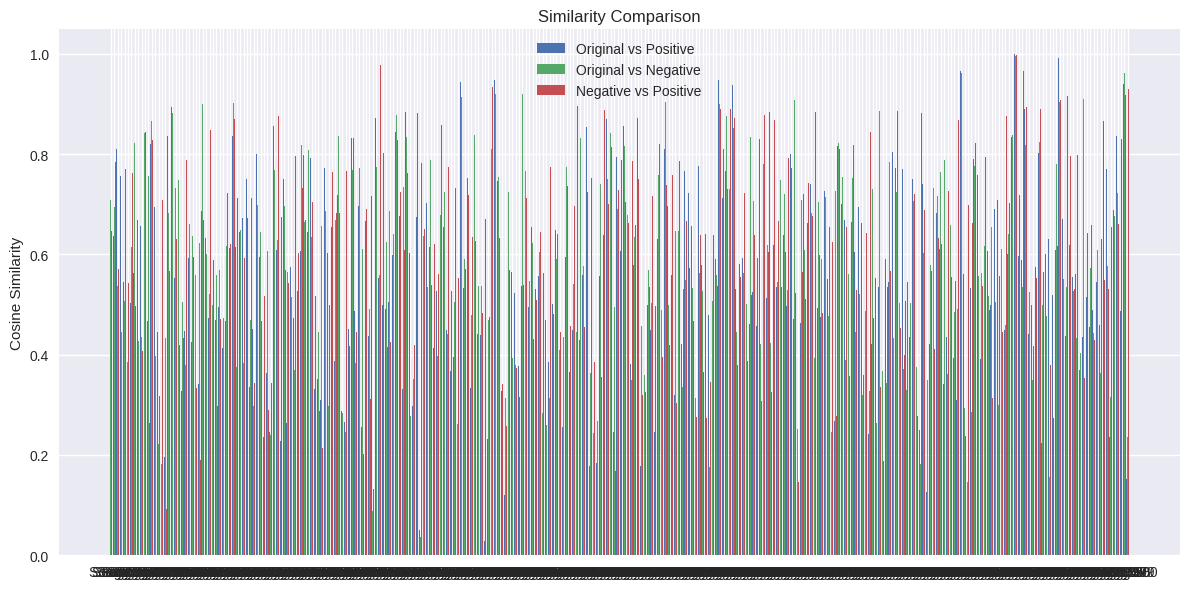

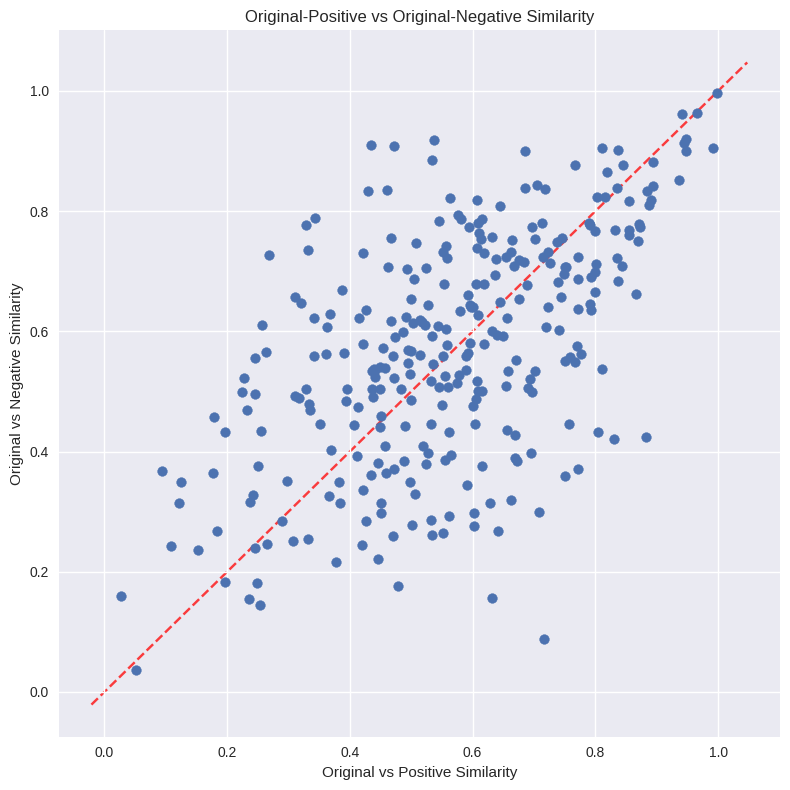

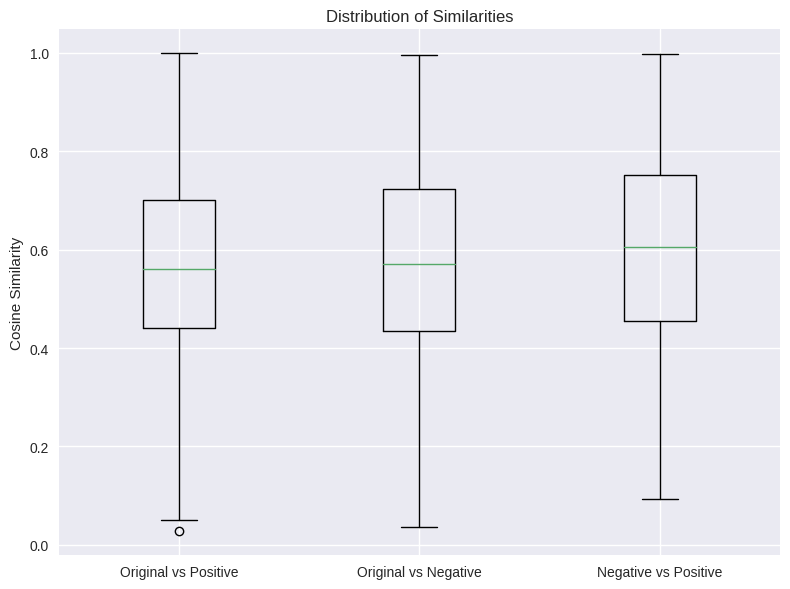

<ipython-input-100-64e906300fc5>:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


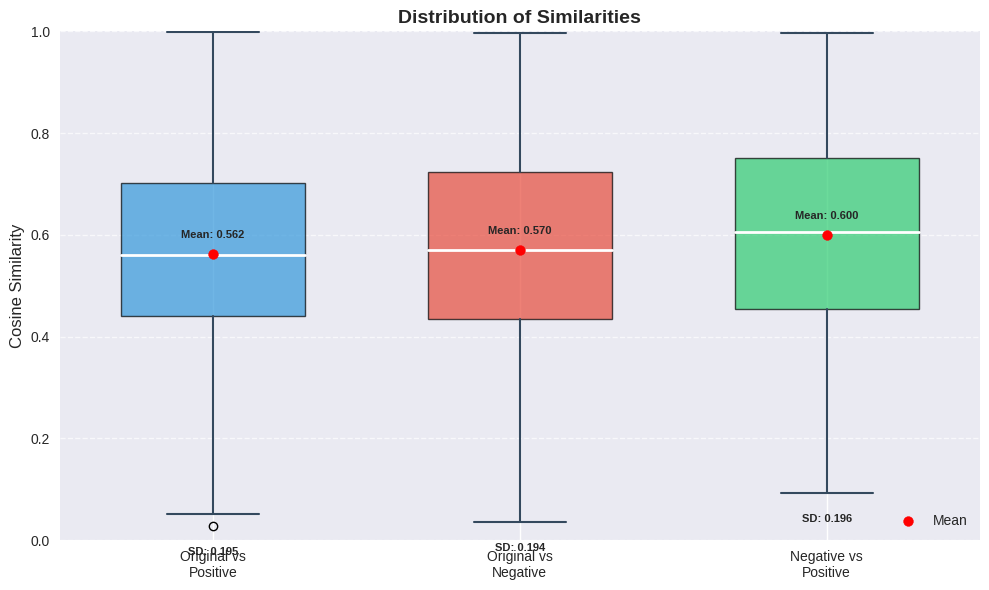

In [ ]:
# @title Plot cosine similarity of original with respect of negative and positive generated samples { display-mode: "form" }
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(original_positive, original_negative, negative_positive):
    n = len(original_positive)
    ind = np.arange(n)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(ind, original_positive, width, label='Original vs Positive')
    rects2 = ax.bar(ind + width, original_negative, width, label='Original vs Negative')
    rects3 = ax.bar(ind + 2*width, negative_positive, width, label='Negative vs Positive')

    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Similarity Comparison')
    ax.set_xticks(ind + width)
    ax.set_xticklabels([f'Song {i+1}' for i in range(n)])
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_scatter(original_positive, original_negative):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(original_positive, original_negative)
    ax.set_xlabel('Original vs Positive Similarity')
    ax.set_ylabel('Original vs Negative Similarity')
    ax.set_title('Original-Positive vs Original-Negative Similarity')

    # Add diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

    plt.tight_layout()
    plt.show()

def plot_box(original_positive, original_negative, negative_positive):
    data = [original_positive, original_negative, negative_positive]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(data)
    ax.set_xticklabels(['Original vs Positive', 'Original vs Negative', 'Negative vs Positive'])
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Distribution of Similarities')
    plt.tight_layout()
    plt.show()

def plot_enhanced_rectangular_box(original_positive, original_negative, negative_positive):
    data = [original_positive, original_negative, negative_positive]
    labels = ['Original vs\nPositive', 'Original vs\nNegative', 'Negative vs\nPositive']

    # Set the style
    plt.style.use('seaborn')

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the box plot
    bp = ax.boxplot(data, patch_artist=True, widths=0.6)

    # Customise colors
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Customise whiskers, caps, and fliers
    for element in ['whiskers', 'caps', 'fliers']:
        for item in bp[element]:
            item.set_color('#34495e')
            item.set_linewidth(1.5)

    # Customise medians
    for median in bp['medians']:
        median.set_color('white')
        median.set_linewidth(2)

    # Set labels and title
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.set_title('Distribution of Similarities', fontsize=14, fontweight='bold')

    # Add a subtle grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add mean points
    means = [np.mean(d) for d in data]
    ax.scatter(range(1, len(data) + 1), means, color='red', s=50, zorder=3, label='Mean')

    # Add value annotations
    for i, (m, d) in enumerate(zip(means, data)):
        ax.annotate(f'Mean: {m:.3f}', (i + 1, m), xytext=(0, 10),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=8, fontweight='bold')
        ax.annotate(f'SD: {np.std(d):.3f}', (i + 1, np.min(d)), xytext=(0, -15),
                    textcoords='offset points', ha='center', va='top',
                    fontsize=8, fontweight='bold')

    # Add legend
    ax.legend(loc='lower right')

    # Set y-axis limits to ensure consistent box sizes
    # Assuming similarity scores are between 0 and 1
    ax.set_ylim(0, 1)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_bar_chart(original_positive_list, original_negative_list, negative_positive_list)
plot_scatter(original_positive_list, original_negative_list)
plot_box(original_positive_list, original_negative_list, negative_positive_list)
plot_enhanced_rectangular_box(original_positive_list, original_negative_list, negative_positive_list)

In [ ]:
# @title Print cosine similarity table per sample { display-mode: "form" }

import pandas as pd
import numpy as np

def create_similarity_table(original_positive, original_negative, negative_positive):
    # Create a DataFrame
    df = pd.DataFrame({
        'Song': [f'Song {i+1}' for i in range(len(original_positive))],
        'Original vs Positive': original_positive,
        'Original vs Negative': original_negative,
        'Negative vs Positive': negative_positive
    })

    # Add a row with mean values
    mean_row = pd.DataFrame({
        'Song': ['Mean'],
        'Original vs Positive': [np.mean(original_positive)],
        'Original vs Negative': [np.mean(original_negative)],
        'Negative vs Positive': [np.mean(negative_positive)]
    })

    df = pd.concat([df, mean_row], ignore_index=True)

    # Format float values to 3 decimal places
    float_cols = ['Original vs Positive', 'Original vs Negative', 'Negative vs Positive']
    df[float_cols] = df[float_cols].applymap('{:.3f}'.format)

    return df

similarity_table = create_similarity_table(original_positive_list, original_negative_list, negative_positive_list)
#print(similarity_table)

#To display the table in a Jupyter notebook with styling:
from IPython.display import display
display(similarity_table.style.highlight_max(axis=1, color='lightgreen').highlight_min(axis=1, color='lightpink'))

<ipython-input-91-03f59185de92>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[float_cols] = df[float_cols].applymap('{:.3f}'.format)


## Latent representation

In [ ]:
# @title Create train, test and validation sets
def print_dataset_shapes(dataset_dict, name):
    print(f"\n{name} dataset shapes:")
    for key, tensor in dataset_dict.items():
        print(f"  {key}: {tensor.shape}")

def shuffle_dataset(dataset):
    # Get the number of samples
    num_samples = next(iter(dataset.values())).shape[0]

    # Generate a random permutation of indices
    indices = torch.randperm(num_samples)

    # Create a new dictionary with shuffled data
    shuffled_dataset = {key: tensor[indices] for key, tensor in dataset.items()}

    return shuffled_dataset

num_files = encoder_input_tensor.shape[0]

# Create a dictionary of the dataset
emotionwave_dataset = {
    'encoder_input': encoder_input_tensor,
    'decoder_input': decoder_input_tensor,
    'decoder_target': decoder_target_tensor,
    'decoder_bar_position': decoder_bar_position_tensor,
    'padding_mask': padding_mask_tensor,
    'valence_cls': valence_cls_tensor,
}

emotionwave_dataset = shuffle_dataset(emotionwave_dataset)

# Calculate from which file the validation set starts
valid_start = round(0.8 * num_files)
# Calculate from which file the test set starts
test_start = round(0.9 * num_files)

# Create train, validation, and test dictionaries
train_data = {
    'encoder_input': encoder_input_tensor[:valid_start],
    'decoder_input': decoder_input_tensor[:valid_start],
    'decoder_target': decoder_target_tensor[:valid_start],
    'decoder_bar_position': decoder_bar_position_tensor[:valid_start],
    'padding_mask': padding_mask_tensor[:valid_start],
    'valence_cls': valence_cls_tensor[:valid_start],
}

valid_data = {
    'encoder_input': encoder_input_tensor[valid_start:test_start],
    'decoder_input': decoder_input_tensor[valid_start:test_start],
    'decoder_target': decoder_target_tensor[valid_start:test_start],
    'decoder_bar_position': decoder_bar_position_tensor[valid_start:test_start],
    'padding_mask': padding_mask_tensor[valid_start:test_start],
    'valence_cls': valence_cls_tensor[valid_start:test_start],
}

test_data = {
    'encoder_input': encoder_input_tensor[test_start:],
    'decoder_input': decoder_input_tensor[test_start:],
    'decoder_target': decoder_target_tensor[test_start:],
    'decoder_bar_position': decoder_bar_position_tensor[test_start:],
    'padding_mask': padding_mask_tensor[test_start:],
    'valence_cls': valence_cls_tensor[test_start:],
}


# Print information about train, validation and test
print_dataset_shapes(train_data, "Train")
print_dataset_shapes(valid_data, "Validation")
print_dataset_shapes(test_data, "Test")


Train dataset shapes:
  encoder_input: torch.Size([40784, 128, 8])
  decoder_input: torch.Size([40784, 1024])
  decoder_target: torch.Size([40784, 1024])
  decoder_bar_position: torch.Size([40784, 9])
  padding_mask: torch.Size([40784, 8, 128])
  valence_cls: torch.Size([40784, 1024])

Validation dataset shapes:
  encoder_input: torch.Size([5098, 128, 8])
  decoder_input: torch.Size([5098, 1024])
  decoder_target: torch.Size([5098, 1024])
  decoder_bar_position: torch.Size([5098, 9])
  padding_mask: torch.Size([5098, 8, 128])
  valence_cls: torch.Size([5098, 1024])

Test dataset shapes:
  encoder_input: torch.Size([5098, 128, 8])
  decoder_input: torch.Size([5098, 1024])
  decoder_target: torch.Size([5098, 1024])
  decoder_bar_position: torch.Size([5098, 9])
  padding_mask: torch.Size([5098, 8, 128])
  valence_cls: torch.Size([5098, 1024])


In [ ]:
# @title Loaders
from torch.utils.data import Dataset, DataLoader
import pickle

class DictDataset(Dataset):
    def __init__(self, tensor_dict):
        self.tensor_dict = tensor_dict
        self.keys = list(tensor_dict.keys())

    def __getitem__(self, index):
        return {key: tensor[index] for key, tensor in self.tensor_dict.items()}

    def __len__(self):
        return len(next(iter(self.tensor_dict.values())))

def create_dataloader(data_dict, batch_size, shuffle=False):
    # Convert all tensors to torch tensors if they aren't already
    tensor_dict = {k: torch.tensor(v) if not isinstance(v, torch.Tensor) else v for k, v in data_dict.items()}

    # Create a DictDataset
    dataset = DictDataset(tensor_dict)

    # Create and return a DataLoader
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def print_dataset_info(data_dict, loader, name):
    print(f"\n{name} Dataset Information:")

    # Print full dataset shapes
    print("Full dataset shapes:")
    for key, tensor in data_dict.items():
        print(f"  {key}: {tensor.shape}")

    # Print shapes of the first batch
    for batch in loader:
        print("\nShapes of tensors in the first batch:")
        for key, tensor in batch.items():
            print(f"  {key}: {tensor.shape}")
        break  # We only want to see the first batch

    print(f"\nNumber of batches: {len(loader)}")
    print(f"Batch size: {loader.batch_size}")
    total_samples = len(loader.dataset)
    print(f"Total number of samples: {total_samples}")

# Size of each batch
batch_size = 4

# Create DataLoaders for each set
train_loader = create_dataloader(train_data, batch_size, shuffle=True)
valid_loader = create_dataloader(valid_data, batch_size, shuffle=False)
test_loader = create_dataloader(test_data, batch_size, shuffle=False)

# Print information for each dataset
print_dataset_info(train_data, train_loader, "Training")
print_dataset_info(valid_data, valid_loader, "Validation")
print_dataset_info(test_data, test_loader, "Test")


Training Dataset Information:
Full dataset shapes:
  encoder_input: torch.Size([40784, 128, 8])
  decoder_input: torch.Size([40784, 1024])
  decoder_target: torch.Size([40784, 1024])
  decoder_bar_position: torch.Size([40784, 9])
  padding_mask: torch.Size([40784, 8, 128])
  valence_cls: torch.Size([40784, 1024])

Shapes of tensors in the first batch:
  encoder_input: torch.Size([4, 128, 8])
  decoder_input: torch.Size([4, 1024])
  decoder_target: torch.Size([4, 1024])
  decoder_bar_position: torch.Size([4, 9])
  padding_mask: torch.Size([4, 8, 128])
  valence_cls: torch.Size([4, 1024])

Number of batches: 10196
Batch size: 4
Total number of samples: 40784

Validation Dataset Information:
Full dataset shapes:
  encoder_input: torch.Size([5098, 128, 8])
  decoder_input: torch.Size([5098, 1024])
  decoder_target: torch.Size([5098, 1024])
  decoder_bar_position: torch.Size([5098, 9])
  padding_mask: torch.Size([5098, 8, 128])
  valence_cls: torch.Size([5098, 1024])

Shapes of tensors in 

In [ ]:
# @title Collect latent space representations { display-mode: "form" }
import torch
import numpy as np
from tqdm import tqdm


def collect_latent_representations(model, data_loader, device):
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_id, batch_inputs in enumerate(data_loader):
            batch_num = batch_id % batch_inputs['encoder_input'].size(0)
            # Put data in the GPU and accommodate the columns
            encoder_input = batch_inputs['encoder_input'][batch_num].to(device, dtype=torch.long)
            padding_mask = batch_inputs['padding_mask'][batch_num].to(device, dtype=torch.bool)
            valence_cls = batch_inputs['valence_cls'].permute(1,0).to(device, dtype=torch.long)

            # Use valence with same value for all the vector
            #valence_cls = torch.full((sequence_length,), i + 1).to(device)
            #valence_cls = None

            # Get the model outputs: mu (mean), logvar (log variance), and decoder logits
            g_latent = get_latent_embedding(model, encoder_input, padding_mask)
            g_latent_np = g_latent.cpu().numpy()

            latent_vectors.append(g_latent_np)

            labels_np = np.full((8,), valence_cls[0, 0].cpu().numpy())
            labels.append(labels_np)

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels


latent_vectors, labels = collect_latent_representations(emw_model, test_loader, device)
print("Final latent vectors shape:", latent_vectors.shape)
print("Final labels shape:", labels.shape)

Final latent vectors shape: (10200, 128)
Final labels shape: (10200,)


In [ ]:
# @title Helper functions to visualise the latent space { display-mode: "form" }

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_latent_space_tsne(latent_vectors, labels):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of latent space')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()



def visualize_latent_space_pca(latent_vectors, labels):
    # Apply PCA
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('PCA visualization of latent space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    # Print explained variance ratio
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

def analyze_latent_statistics(latent_vectors, labels):
    print(f"Latent space shape: {latent_vectors.shape}")
    print(f"Mean: {np.mean(latent_vectors, axis=0)}")
    print(f"Standard deviation: {np.std(latent_vectors, axis=0)}")

    # Compute mean latent vector for each class
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_vectors = latent_vectors[labels == label]
        print(f"\nClass {label}:")
        print(f"Mean: {np.mean(class_vectors, axis=0)}")
        print(f"Standard deviation: {np.std(class_vectors, axis=0)}")

def latent_label_correlation(latent_vectors, labels):
    correlations = []
    for i in range(latent_vectors.shape[1]):
        corr = np.corrcoef(latent_vectors[:, i], labels)[0, 1]
        correlations.append(corr)

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(correlations)), correlations)
    plt.title('Correlation between latent dimensions and labels')
    plt.xlabel('Latent dimension')
    plt.ylabel('Correlation coefficient')
    plt.show()

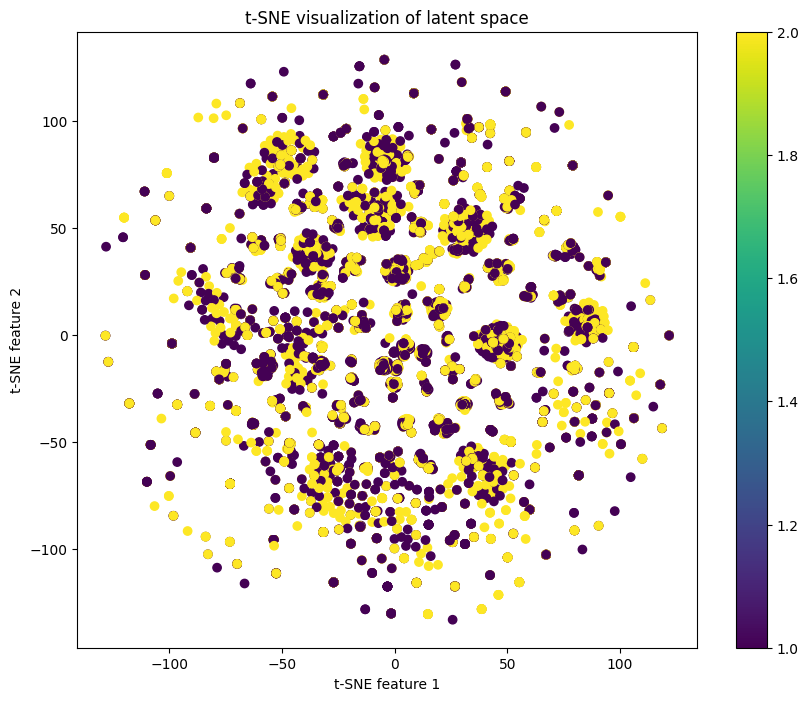

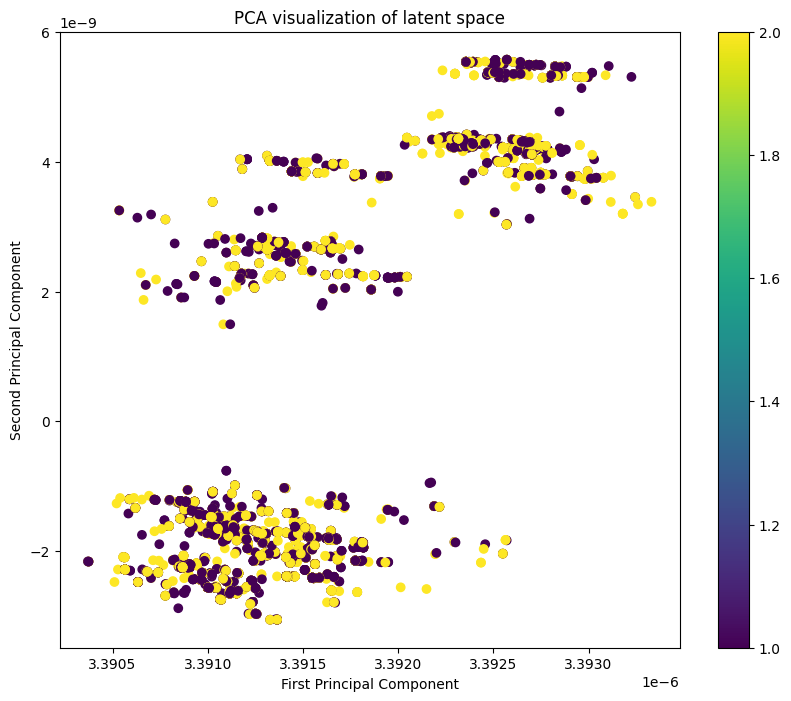

Explained variance ratio: [9.9999654e-01 7.6861210e-07]
Latent space shape: (10200, 128)
Mean: [-1.2674329e-03  6.4422134e-03  3.4367142e-03  4.7009643e-03
 -9.0312434e-04 -3.9164526e-03  1.0252227e-03 -6.9995229e-03
 -1.0919520e-03  1.0121992e-03  8.6281858e-03 -5.4896092e-03
  6.0302881e-03 -6.6985949e-03 -4.3435795e-03  4.9524545e-03
  3.3288612e-03  3.4356541e-03  2.2888514e-03 -6.5987450e-03
 -3.3183568e-03 -3.5378102e-03 -2.4476242e-03 -2.5425237e-03
  2.4158340e-05 -4.2481851e-03 -1.5604052e-03 -1.0700390e-03
  4.1545611e-03  6.2635508e-03 -1.6286601e-03  7.2128917e-03
  3.4827916e-03 -5.3626799e-04  5.9468653e-03  2.2805433e-03
 -4.2148185e-04  3.1776149e-03  2.0345545e-03  1.4818205e-03
 -6.4612825e-05 -2.6646785e-03  3.0174493e-03 -3.2520967e-03
  2.9507952e-03  6.0721980e-03  2.3823173e-03  4.7873301e-04
 -5.1386715e-03 -7.6093816e-04  1.1313059e-03  5.4181705e-04
 -4.9781227e-03 -2.8977769e-03 -4.2650834e-04 -4.2790365e-03
  4.2804396e-03  2.7791399e-03  1.0386202e-03 -2.57

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


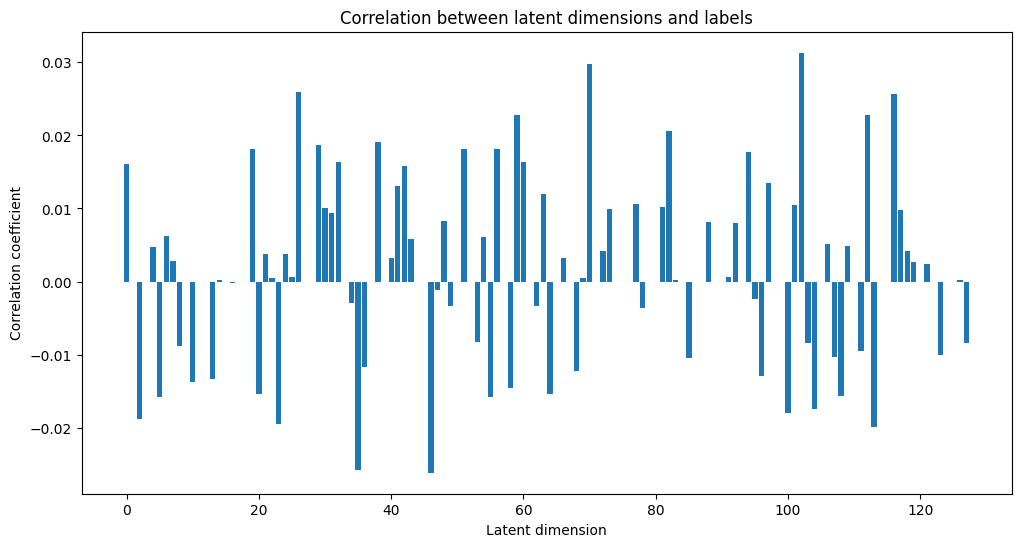

In [ ]:
# @title Lets take a look to the latent space with respect of valence { display-mode: "form" }
# @markdown Since the latent space does not include any valence information is not expected to
# @markdown see any clustering with respect to valence. Instead, this latent space contains the
# @markdown the relationships of the tokens in each bar.
# Visualize with t-SNE
visualize_latent_space_tsne(latent_vectors, labels)

# Visualize with PCA
visualize_latent_space_pca(latent_vectors, labels)

# Analyze latent space statistics
analyze_latent_statistics(latent_vectors, labels)

# Check correlation between latent dimensions and labels
latent_label_correlation(latent_vectors, labels)